Load the dataset from Jeff Sackmann's GitHub

In [ ]:
import pandas as pd


years = range(2015, 2024)
dfs = []

for year in years:
    url = f"https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv"
    try:
        df_year = pd.read_csv(url)
        df_year['year'] = year
        dfs.append(df_year)
    except Exception as e:
        print(f"Failed to load {year}: {e}")

# Combine into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all[~df_all['tourney_name'].str.contains('Davis Cup', case=False, na=False)]
df_all['tourney_name'] = df_all['tourney_name'].str.strip().str.lower()


/tmp/ipython-input-2-2710105605.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['tourney_name'] = df_all['tourney_name'].str.strip().str.lower()


Create a data frame with just the Grand Slams from years 2015-2024

In [ ]:
#create a datframe of just the grand slams for the years. 2015-2023

df_slams = df_all[
    (df_all['tourney_name'].isin([
        'australian open', 'roland garros', 'wimbledon', 'us open'
    ])) &
    (df_all['year'].between(2015, 2024))
]

Feature engineering - Match Dominance score, rank_diff, serve_efficiency, sets_played, fatigue, total_games_played , total_games_won, games_won_ratio and bp_saved_ratio all added to df_slams.

In [ ]:


# Serve Efficiency
df_slams.loc[:, 'serve_efficiency'] = (
    df_slams['w_1stWon'] / (df_slams['w_1stIn'] + 1) +
    df_slams['w_2ndWon'] / (df_slams['w_svpt'] - df_slams['w_1stIn'] + 1)
)

# Rank Difference
df_slams.loc[:, 'rank_diff'] = df_slams['loser_rank'] - df_slams['winner_rank']

# Sets Played
df_slams.loc[:, 'sets_played'] = df_slams['score'].apply(
    lambda s: len(str(s).split()) if pd.notnull(s) else None
)

# Fatigue Estimate
df_slams.loc[:, 'fatigue'] = df_slams['sets_played'] * df_slams['minutes']

# Fixed parse_score_to_games function
def parse_score_to_games(score_str):
    winner_games = 0
    loser_games = 0

    if pd.isnull(score_str):
        return pd.NA, pd.NA

    sets = score_str.strip().split()
    for s in sets:
        s = s.split('(')[0]
        try:
            w, l = map(int, s.split('-'))
            winner_games += w
            loser_games += l
        except:
            return pd.NA, pd.NA

    return winner_games, loser_games

# Apply and extract game counts
parsed_scores = df_slams['score'].apply(parse_score_to_games)
df_slams.loc[:, 'winner_games'] = parsed_scores.apply(lambda x: x[0])
df_slams.loc[:, 'loser_games'] = parsed_scores.apply(lambda x: x[1])
df_slams.loc[:, 'total_games_played'] = df_slams['winner_games'] + df_slams['loser_games']
df_slams.loc[:, 'total_games_won'] = df_slams['winner_games']

# Ratios
df_slams.loc[:, 'games_won_ratio'] = df_slams['total_games_won'] / df_slams['total_games_played']
df_slams.loc[:, 'bp_save_ratio'] = df_slams['w_bpSaved'] / (df_slams['w_bpFaced'] + 1)

# Match Dominance Score
df_slams.loc[:, 'match_dominance_score'] = (
    0.4 * df_slams['games_won_ratio'].fillna(0) +
    0.3 * df_slams['serve_efficiency'].fillna(0) +
    0.2 * df_slams['bp_save_ratio'].fillna(0) +
    0.1 * (df_slams['w_ace'] - df_slams['w_df']).fillna(0) / (df_slams['w_svpt'] + 1)
)
df_slams.head(10)

/tmp/ipython-input-4-2229127249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slams.loc[:, 'serve_efficiency'] = (
/tmp/ipython-input-4-2229127249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slams.loc[:, 'rank_diff'] = df_slams['loser_rank'] - df_slams['winner_rank']
/tmp/ipython-input-4-2229127249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,rank_diff,sets_played,fatigue,winner_games,loser_games,total_games_played,total_games_won,games_won_ratio,bp_save_ratio,match_dominance_score
139,2015-580,australian open,Hard,128,G,20150119,1,104925,1.0,NaN,...,115.0,3,327.0,18,9,27,18,0.666667,0.750000,0.854116
140,2015-580,australian open,Hard,128,G,20150119,2,105723,NaN,NaN,...,-27.0,4,608.0,22,16,38,22,0.578947,0.666667,0.758735
141,2015-580,australian open,Hard,128,G,20150119,3,104424,NaN,NaN,...,120.0,5,1035.0,23,22,45,23,0.511111,0.600000,0.678581
142,2015-580,australian open,Hard,128,G,20150119,4,104269,31.0,NaN,...,70.0,4,648.0,21,15,36,21,0.583333,0.600000,0.693832
143,2015-580,australian open,Hard,128,G,20150119,5,104545,19.0,NaN,...,97.0,3,381.0,19,14,33,19,0.575758,0.500000,0.812192
144,2015-580,australian open,Hard,128,G,20150119,6,104890,NaN,NaN,...,180.0,4,644.0,23,18,41,23,0.560976,0.555556,0.732759
145,2015-580,australian open,Hard,128,G,20150119,7,104180,NaN,NaN,...,10.0,3,429.0,20,16,36,20,0.555556,0.900000,0.830183
146,2015-580,australian open,Hard,128,G,20150119,8,105138,13.0,NaN,...,24.0,4,716.0,23,17,40,23,0.575,0.869565,0.759271
147,2015-580,australian open,Hard,128,G,20150119,9,103852,12.0,NaN,...,109.0,5,970.0,29,24,53,29,0.54717,0.444444,0.711241
148,2015-580,australian open,Hard,128,G,20150119,10,105173,NaN,NaN,...,44.0,3,414.0,19,11,30,19,0.633333,0.800000,0.800404


adding round reached for each player for each tournamnent, new round_reached column per player. This is our target feature.

In [ ]:
# Round scoring map
round_order = ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F', 'W']
round_to_score = {rnd: i for i, rnd in enumerate(round_order)}

# Long-form player results across ALL years in df_slams
player_rounds = pd.concat([
    df_slams[['tourney_name', 'year', 'winner_name', 'round']].rename(columns={'winner_name': 'player_name'}),
    df_slams[['tourney_name', 'year', 'loser_name', 'round']].rename(columns={'loser_name': 'player_name'})
], ignore_index=True)

# Map round to numeric score
player_rounds['round_value'] = player_rounds['round'].map(round_to_score)

# Max round reached per player per tournament per year
player_max_round = (
    player_rounds.groupby(['tourney_name', 'year', 'player_name'])['round_value']
    .max()
    .reset_index()
    .rename(columns={'round_value': 'round_reached'})
)
df_slams = df_slams.drop(columns=['winner_round_reached', 'loser_round_reached'], errors='ignore')

df_slams = df_slams.merge(
    player_max_round,
    how='left',
    left_on=['tourney_name', 'year', 'winner_name'],
    right_on=['tourney_name', 'year', 'player_name']
).rename(columns={'round_reached': 'winner_round_reached'}).drop(columns='player_name')

df_slams = df_slams.merge(
    player_max_round,
    how='left',
    left_on=['tourney_name', 'year', 'loser_name'],
    right_on=['tourney_name', 'year', 'player_name']
).rename(columns={'round_reached': 'loser_round_reached'}).drop(columns='player_name')


This is to find out which features are the most important for each tournament/specific years etc

In [ ]:
def tournament_feature_importance(df, tourney_name, years, test_size=0.2, plot=True):
    """
    Train XGBoost to predict round reached from R128 performance,
    pooling multiple years of a specific tournament together.
    """
    if isinstance(years, int):
        years = [years]  # Handle single year input

    # Filter for tournament and all specified years
    df_tourney = df[
        (df['tourney_name'].str.strip().str.lower() == tourney_name.strip().lower()) &
        (df['year'].isin(years))
    ].copy()

    if df_tourney.empty:
        print(f"No data found for {tourney_name} in years {years}")
        return None

    # Filter for R128 matches as predictors
    r128 = df_tourney[df_tourney['round'] == 'R128'].copy()

    if r128.empty:
        print(f"No R128 data found for {tourney_name} in years {years}")
        return None

    if 'winner_round_reached' not in r128.columns:
        print("Missing 'winner_round_reached' — compute round tracking first.")
        return None

    r128['winner_round_reached'] = pd.to_numeric(r128['winner_round_reached'], errors='coerce')
    r128 = r128[r128['winner_round_reached'].notna()]

    if r128.empty:
        print(f"No valid targets for {tourney_name} in years {years}")
        return None

    # Feature selection
    exclude_cols = ['winner_round_reached', 'winner_name', 'loser_name', 'score', 'round', 'winner_seed', 'winner_rank_points','winner_rank','loser_rank','loser_rank_points','tourney_date','rank_diff','winner_id','match_num','year','winner_ht','loser_ht','loser_id','loser_seed','loser_age','winner_age']
    numeric_cols = r128.select_dtypes(include=['number']).columns.difference(exclude_cols)
    X = r128[numeric_cols]
    y = r128['winner_round_reached']

    if X.empty:
        print(f"No valid numeric features for {tourney_name} in years {years}")
        return None

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{tourney_name.title()} {years} - Test MSE: {mse:.4f}")

    # Feature importance
    importance = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False)

    # Plot
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        xgb.plot_importance(model, importance_type='gain', ax=ax, show_values=False)
        plt.title(f"Feature Importance for {tourney_name.title()} ({min(years)}–{max(years)})")
        plt.tight_layout()
        plt.show()

    return importance_df


Wimbledon [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024] - Test MSE: 1.8429


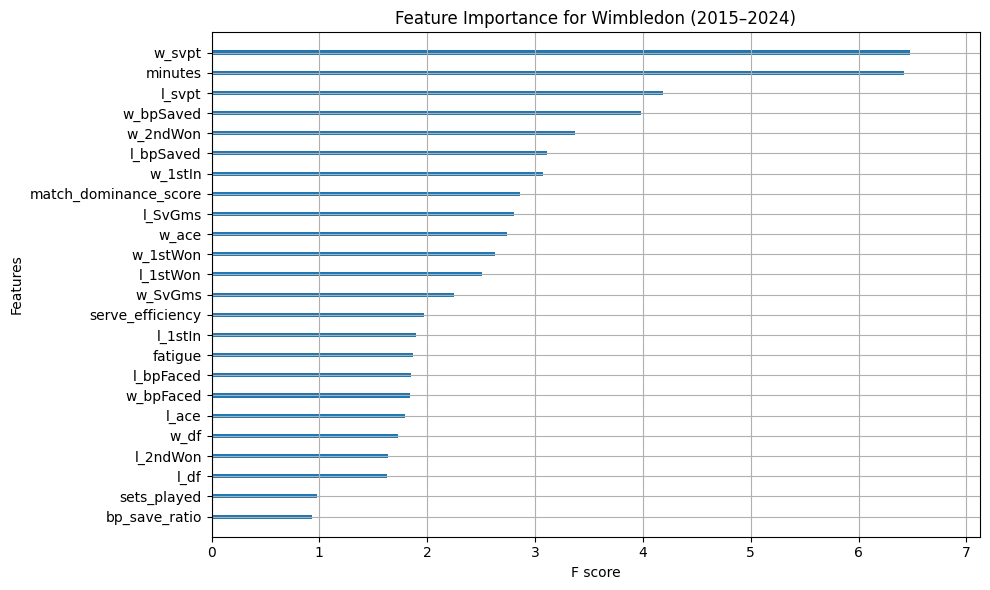

In [ ]:
importance_range = tournament_feature_importance(df_slams, "wimbledon", list(range(2015, 2025)))


Wimbledon [2023] - Test MSE: 2.9945


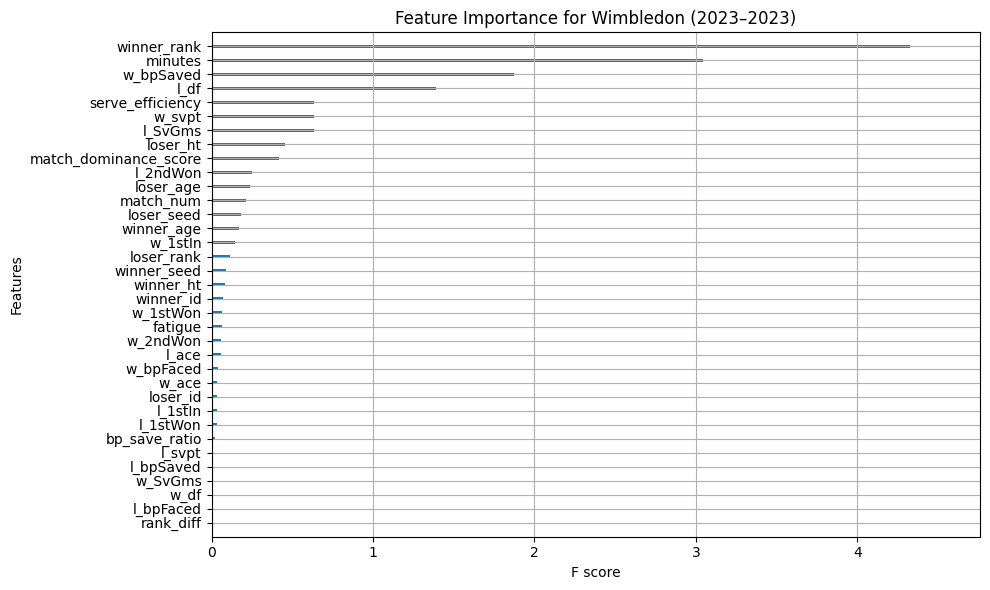

In [ ]:
importance_wim_2023 = tournament_feature_importance(df_slams, "wimbledon", 2023)



This is the pipeline for accuracy etc. The model will train on the features that we chose for the tournament that we chose.

In [ ]:
!pip install mord


  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=84edeab39321de82dabcfdab03fab3b3b32898e3829c42bf4895e605d40b727f
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


             player_name  ml_performance_score  round_reached
0      Matteo Berrettini              5.680814              7
1         Cameron Norrie              4.757627              6
2          Gilles Muller              4.672337              5
3        Karen Khachanov              4.402130              5
4       Marton Fucsovics              4.312802              5
5       Denis Shapovalov              4.227150              6
6         Carlos Alcaraz              4.019682              4
7  Juan Martin del Potro              3.987349              5
8            Guido Pella              3.901466              5
9          Lucas Pouille              3.873739              5


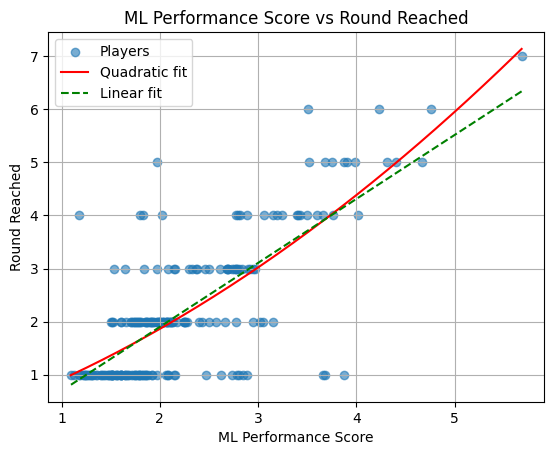


Quadratic Coefficients: [0.10243132 0.64601443 0.16138296]
Quadratic R²: 0.571
Linear R²: 0.566
Spearman Correlation (rank-based): 0.675
Ordinal Ridge Accuracy: 0.59


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


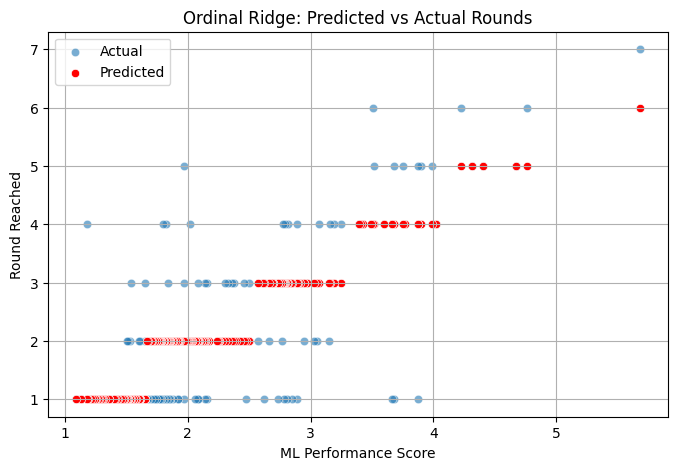

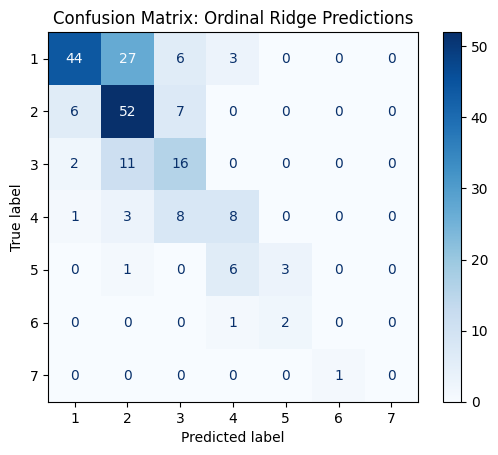

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

# Define most important features
final_features = [
    'w_svpt',
    'minutes',
    'l_svpt',
    'w_bpSaved',
    'w_2ndWon',
    'match_dominance_score'
]

def get_tournament_matches(df, tourney_name, years):
    return df[
        (df['tourney_name'].str.lower() == tourney_name.lower()) &
        (df['year'].between(min(years), max(years)))
    ].copy()

def get_player_max_round(df, round_mapping):
    player_rounds = pd.concat([
        df[['winner_name', 'round_value']].rename(columns={'winner_name': 'player_name'}),
        df[['loser_name', 'round_value']].rename(columns={'loser_name': 'player_name'})
    ])
    return (player_rounds.groupby('player_name')['round_value']
            .max().reset_index().rename(columns={'round_value': 'round_reached'}))

def prep_r128_player_features(df_r128, final_features):
    winner_df = df_r128[[*final_features, 'winner_name']].rename(columns={'winner_name': 'player_name'})
    loser_df = df_r128[[*final_features, 'loser_name']].rename(columns={'loser_name': 'player_name'})
    df_players = pd.concat([winner_df, loser_df], ignore_index=True)
    return (df_players.drop_duplicates('player_name').dropna(subset=final_features))

def train_tournament_model(df_players, final_features):
    X = df_players[final_features]
    y = df_players['round_reached']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1
    )
    model.fit(X_train, y_train)
    return model

def run_reseeding_pipeline(df_slams, tourney_name, years, final_features, round_mapping):
    df_matches = get_tournament_matches(df_slams, tourney_name, years)
    df_matches['round_value'] = df_matches['round'].map(round_mapping)

    player_max_round = get_player_max_round(df_matches, round_mapping)
    df_r128 = df_matches[df_matches['round'] == 'R128'].copy()
    missing = [feat for feat in final_features if feat not in df_r128.columns]
    if missing:
        raise ValueError(f"Missing final_features in R128 data: {missing}")

    df_players = prep_r128_player_features(df_r128, final_features)
    df_players = df_players.merge(player_max_round, on='player_name', how='left').dropna(subset=['round_reached'])

    model = train_tournament_model(df_players, final_features)
    df_players['ml_performance_score'] = model.predict(df_players[final_features])
    df_players = df_players.sort_values(by='ml_performance_score', ascending=False).reset_index(drop=True)
    return df_players, model

def plot_quadratic_regression(df_players):
    """Plot quadratic + linear regression, compute Spearman correlation."""

    X = df_players['ml_performance_score'].values
    y = df_players['round_reached'].values

    # Quadratic fit
    coeffs = np.polyfit(X, y, deg=2)
    X_curve = np.linspace(X.min(), X.max(), 200)
    y_curve = np.polyval(coeffs, X_curve)

    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X.reshape(-1, 1), y)
    y_lin_pred = lin_reg.predict(X.reshape(-1, 1))

    # Spearman correlation
    spearman_corr, _ = spearmanr(X, y)

    # Plot
    plt.scatter(X, y, alpha=0.6, label="Players")
    plt.plot(X_curve, y_curve, color='red', label='Quadratic fit')
    plt.plot(X, y_lin_pred, color='green', linestyle='--', label='Linear fit')
    plt.xlabel('ML Performance Score')
    plt.ylabel('Round Reached')
    plt.title('ML Performance Score vs Round Reached')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Metrics
    y_pred_quad = np.polyval(coeffs, X)
    r2_quad = 1 - np.sum((y - y_pred_quad)**2) / np.sum((y - y.mean())**2)
    r2_lin = lin_reg.score(X.reshape(-1, 1), y)

    print(f"\nQuadratic Coefficients: {coeffs}")
    print(f"Quadratic R²: {r2_quad:.3f}")
    print(f"Linear R²: {r2_lin:.3f}")
    print(f"Spearman Correlation (rank-based): {spearman_corr:.3f}")
    return coeffs, r2_quad, r2_lin, spearman_corr


# Your tournament config
TOURNAMENT = 'wimbledon'
YEARS = range(2015, 2023)
round_mapping = {
    'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
    'QF': 5, 'SF': 6, 'F': 7, 'W': 8
}

# Run the pipeline
df_players, model_final = run_reseeding_pipeline(df_slams, TOURNAMENT, YEARS, final_features, round_mapping)
print(df_players[['player_name', 'ml_performance_score', 'round_reached']].head(10))

# Run enhanced regression and correlation analysis
plot_quadratic_regression(df_players)

from mord import OrdinalRidge
X = df_players[['ml_performance_score']]
y = df_players['round_reached'].astype(int)
model = OrdinalRidge().fit(X, y)
df_players['predicted_round'] = model.predict(X)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y, df_players['predicted_round'])
print(f'Ordinal Ridge Accuracy: {accuracy:.2f}')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_players, x='ml_performance_score', y='round_reached', label='Actual', alpha=0.6)
sns.scatterplot(data=df_players, x='ml_performance_score', y='predicted_round', label='Predicted', color='red')
plt.title('Ordinal Ridge: Predicted vs Actual Rounds')
plt.xlabel('ML Performance Score')
plt.ylabel('Round Reached')
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, df_players['predicted_round'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Ordinal Ridge Predictions')
plt.show()

